# Midterm - Spring 2023

## Problem 1: Take-at-home  (45 points total)

You are applying for a position at the data science team of USDA and you are given data associated with determining appropriate parasite treatment of canines. The suggested treatment options are determined based on a **logistic regression** model that predicts if the canine is infected with a parasite. 

The data is given in the site: https://data.world/ehales/grls-parasite-study/workspace/file?filename=CBC_data.csv  and more specifically in the CBC_data.csv file. Login using you University Google account to access the data and the description that includes a paper on the study (**you dont need to read the paper to solve this problem**). Your target variable $y$ column is titled `parasite_status`. 




### Question 1 - Feature Engineering (5 points)

Write the posterior probability expressions for logistic regression for the problem you are given to solve.

$$p(y=1| \mathbf{x}, \mathbf w) = \frac{p(\mathbf{x}|y=1) p(y=1)}{p(\mathbf{x}|y=1) p(y=1) + p(\mathbf{x}|y=0) p(y=0)} = \sigma(\alpha)$$

$$p(y=0| \mathbf{x}, \mathbf w)= \frac{p(\mathbf{x}|y=0) p(y=0)}{p(\mathbf{x}|y=1) p(y=1) + p(\mathbf{x}|y=0) p(y=0)} = 1- \sigma(\alpha)$$






### Question 2 - Decision Boundary (5 points)

Write the expression for the decision boundary assuming that $p(y=1)=p(y=0)$. The decision boundary is the line that separates the two classes.





$w^{t}x = 0.5$



### Question 3 - Loss function (5 points)

Write the expression of the loss as a function of $\mathbf w$ that makes sense for you to use in this problem. 

NOTE: The loss will be a function that will include this function: 

$$\sigma(a) = \frac{1}{1+e^{-a}}$$



$$L_{CE} = - \big[ \sum_{i=1}^m \{y_i \ln \sigma (w^{t}x) + (1-y_i) \ln (1-\sigma(w^{t}x)) \} \big]$$
 


### Question 4 - Gradient (5 points)

Write the expression of the gradient of the loss with respect to the parameters - show all your work.



$$ \nabla_\mathbf w L_{CE} = - \big[ \sum_{i=1}^m \{y_i \ln w_{i}x + (1-y_i) \ln (1-w_{i}x) \} \big]$$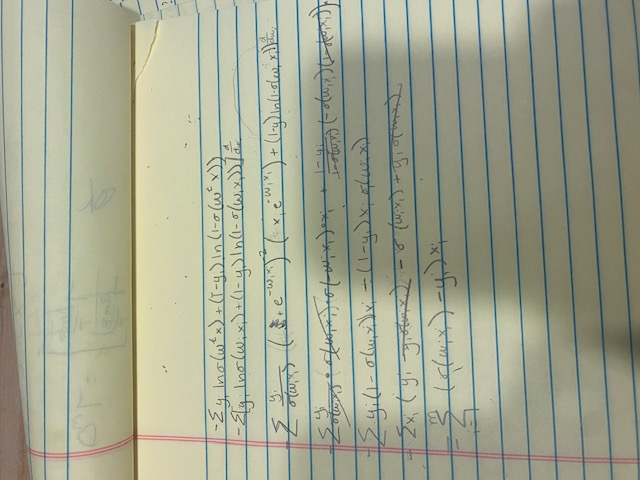


### Question 5 - Imbalanced dataset (10 points)

You are now told that in the dataset  

$$p(y=0) >> p(y=1)$$

Can you comment if the accuracy of Logistic Regression will be affected by such imbalance?

The accuracy of this Logistic Regression will be affected as the training algorithm must be updated to take the imbalanced distribution into account. By specifying a class weight configuration, there will be less penalizations for errors made on examples from the majority class and more on the errors made on examples from the minority class.


### Question 6 - SGD (15 points)

The interviewer was impressed with your answers and wants to test your programming skills. 

1. Use the dataset to train a logistic regressor that will predict the target variable $y$. 

 2. Report the harmonic mean of precision (p) and recall (r) i.e the  [metric called $F_1$ score](https://en.wikipedia.org/wiki/F-score) that is calculated as shown below using a test dataset that is 20% of each group. Plot the $F_1$ score vs the iteration number  $t$. 

$$F_1 = \frac{2}{r^{-1} + p^{-1}}$$

Your code includes hyperparameter optimization of the learning rate and mini batch size. Please learn about cross validation which is a splitting strategy for tuning models [here](https://scikit-learn.org/stable/modules/cross_validation.html).

You are allowed to use any library you want to code this problem.



In [53]:
from pandas._libs.lib import tuples_to_object_array
import pandas
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from  sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

df = pandas.read_csv("sample_data/CBC_data.csv")

df["SEX"] = df["SEX"].astype("category")
df["TYPEAREA"] = df["TYPEAREA"].astype("category")
df["SEX.REPRO"] =  df["SEX.REPRO"].astype("category")
df["REPRO.STATUS"] = df["REPRO.STATUS"].astype("category")
df["PARASITE_STATUS"] = df["PARASITE_STATUS"].astype("category")
cat_columns = df.select_dtypes(['category']).columns
cat_columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

#print(df["PARASITE_STATUS"])

df["AGE"]=(df["AGE"]-df["AGE"].mean())/df["AGE"].std()
df["RBC"]=(df["RBC"]-df["RBC"].mean())/df["RBC"].std()
df["HGB"]=(df["HGB"]-df["HGB"].mean())/df["HGB"].std()
df["WBC"]=(df["WBC"]-df["WBC"].mean())/df["WBC"].std()
df["EOS.CNT"]=(df["EOS.CNT"]-df["EOS.CNT"].mean())/df["EOS.CNT"].std()
df["MONO.CNT"]=(df["MONO.CNT"]-df["MONO.CNT"].mean())/df["MONO.CNT"].std()
df["LYMP.CNT"]=(df["LYMP.CNT"]-df["LYMP.CNT"].mean())/df["LYMP.CNT"].std()
df["NUT.CNT"]=(df["NUT.CNT"]-df["NUT.CNT"].mean())/df["NUT.CNT"].std()
df["PL.CNT"]=(df["PL.CNT"]-df["PL.CNT"].mean())/df["PL.CNT"].std()

df = df.dropna()
X = df[["SEX.REPRO", "AGE", "RBC", "HGB", "WBC", "EOS.CNT", "MONO.CNT", "NUT.CNT", "PL.CNT", "LYMP.CNT"]]
Y = df["PARASITE_STATUS"]

def fscore_function(model, testX, testY):
  prediction = model.predict(testX)
  return f1_score(testY, prediction, pos_label = 1)

kf = KFold(n_splits=10)
kf.get_n_splits(X)
MINI_BATCH_SIZE = 10
a = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = Y)
b = {0: a[0],
     1: a[1]}
f_scores = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
  test_X = X.iloc[test_index]
  test_Y = Y.iloc[test_index]
  train_X = X.iloc[train_index]
  train_Y = Y.iloc[train_index]
  clf = SGDClassifier(max_iter=1000, tol=1e-3, eta0 = 150, class_weight = b)
  for j in range(0, len(train_index), MINI_BATCH_SIZE):
    batchX = train_X[j: min(j+MINI_BATCH_SIZE, len(train_index))]
    batchY = train_Y[j: min(j+ MINI_BATCH_SIZE, len(train_index))]
    clf.partial_fit(batchX, batchY, classes = [0, 1])
  f_scores.append(fscore_function(clf, test_X, test_Y))



pos 0.12087912087912087
neg 0.6172248803827752
pos 0.11249999999999998
neg 0.6772727272727272
pos 0.05263157894736842
neg 0.6785714285714286
pos 0.16666666666666669
neg 0.5707070707070707
pos 0.04054054054054055
neg 0.6844444444444444
pos 0.05031446540880504
neg 0.6560364464692484
pos 0.08139534883720931
neg 0.6291079812206573
pos 0.03389830508474576
neg 0.5938242280285037
pos 0.1408450704225352
neg 0.5246753246753247
pos 0.11235955056179775
neg 0.8447937131630648


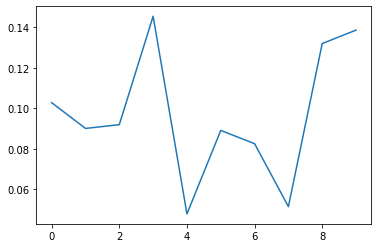

In [47]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(f_scores)